In [1]:
# Core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# For loading and transforming data
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Metrics
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

# Additional utilities
from torch.optim import Adam
from torch.nn import Conv2d, ConvTranspose2d, LeakyReLU, BatchNorm2d
from torchvision.utils import save_image



In [2]:
import os
import shutil

# Base directory where the original folders are located
base_dir = '/kaggle/input/cv-project-detector/Classifier Data'

# New directory where the combined images will be located
new_base_dir = '/kaggle/working/images/'

# Create new directories if they don't exist
os.makedirs(os.path.join(new_base_dir, 'Diseased'), exist_ok=True)
os.makedirs(os.path.join(new_base_dir, 'No_Disease'), exist_ok=True)

# Categories and diseases
categories = ['train', 'val']
diseases = ['Disease_Present', 'No_Disease']

# Copy the files
for cat in categories:
    for disease in diseases:
        # Directory where the current images are located
        old_dir = os.path.join(base_dir, cat, disease)
        
        # Directory where the images are going to be moved to
        new_dir_name = 'Diseased' if disease == 'Disease_Present' else 'No_Disease'
        new_dir = os.path.join(new_base_dir, new_dir_name)

        # Copy each file
        for filename in os.listdir(old_dir):
            old_file = os.path.join(old_dir, filename)
            new_file = os.path.join(new_dir, filename)
            
            # Check if the file already exists, if so, skip or rename
            if not os.path.exists(new_file):
                shutil.copy(old_file, new_file)  # Copy the file
            else:
                # If a file with the same name exists, append an extra identifier before the extension
                base, extension = os.path.splitext(new_file)
                new_filename = base + '_duplicate' + extension
                shutil.copy(old_file, new_filename)


## Vanilla Gans 256 x 256 images

In [3]:
import torch
import torch.nn as nn
import numpy as np

class Generator(nn.Module):
    def __init__(self, z_dim, img_shape, n_classes):
        super(Generator, self).__init__()
        self.img_shape = img_shape  # Storing the image shape as an attribute
        self.label_emb = nn.Embedding(n_classes, n_classes)
        
        self.model = nn.Sequential(
            nn.Linear(z_dim + n_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z, labels):
        c = self.label_emb(labels)
        x = torch.cat([z, c], dim=1)
        img = self.model(x)
        img = img.view(img.size(0), *self.img_shape)
        return img



In [4]:
class Discriminator(nn.Module):
    def __init__(self, img_shape, n_classes):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)) + n_classes, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Flatten image
        img_flat = img.view(img.size(0), -1)
        # Embed labels and concatenate with the image
        c = self.label_emb(labels)
        x = torch.cat([img_flat, c], dim=1)
        validity = self.model(x)
        return validity


In [6]:
# Hyperparameters
import torch.optim as optim
z_dim = 100
img_size = 256
img_channels = 3  # Assuming RGB images
n_classes = 2  # Adjust according to your labels
lr = 3e-4
batch_size = 64
epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Models
generator = Generator(z_dim=z_dim, img_shape=(img_channels, img_size, img_size), n_classes=n_classes).to(device)
discriminator = Discriminator(img_shape=(img_channels, img_size, img_size), n_classes=n_classes).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()


In [7]:
# Image transformations
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Data loaders for your dataset
dataloader = DataLoader(
    datasets.ImageFolder('/kaggle/working/images', transform=transform),
    batch_size=batch_size,
    shuffle=True,
)


[Epoch 0/100] [Batch 137/138] [D loss: 0.3565302789211273] [G loss: 0.7125203013420105]


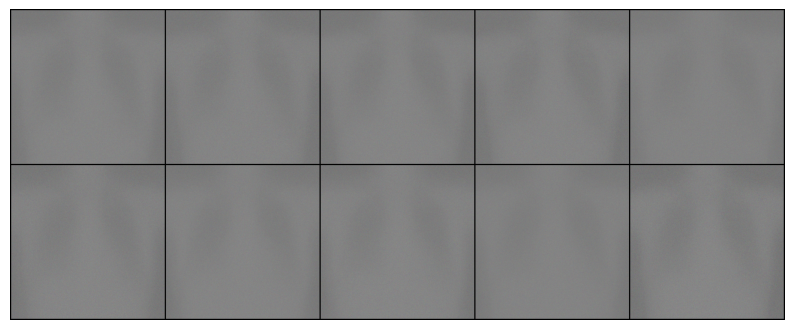

[Epoch 1/100] [Batch 137/138] [D loss: 0.40062564611434937] [G loss: 0.8110572099685669]
[Epoch 2/100] [Batch 137/138] [D loss: 0.686163604259491] [G loss: 1.2192186117172241]
[Epoch 3/100] [Batch 137/138] [D loss: 0.7557463645935059] [G loss: 0.29749199748039246]
[Epoch 4/100] [Batch 137/138] [D loss: 0.3938377797603607] [G loss: 1.1862214803695679]
[Epoch 5/100] [Batch 137/138] [D loss: 0.3045988082885742] [G loss: 1.1041656732559204]
[Epoch 6/100] [Batch 137/138] [D loss: 0.546441912651062] [G loss: 0.977961003780365]
[Epoch 7/100] [Batch 137/138] [D loss: 0.30535414814949036] [G loss: 1.4097448587417603]
[Epoch 8/100] [Batch 137/138] [D loss: 0.38700926303863525] [G loss: 1.1594141721725464]
[Epoch 9/100] [Batch 137/138] [D loss: 0.42922812700271606] [G loss: 1.2025847434997559]
[Epoch 10/100] [Batch 137/138] [D loss: 0.46743524074554443] [G loss: 0.820356547832489]


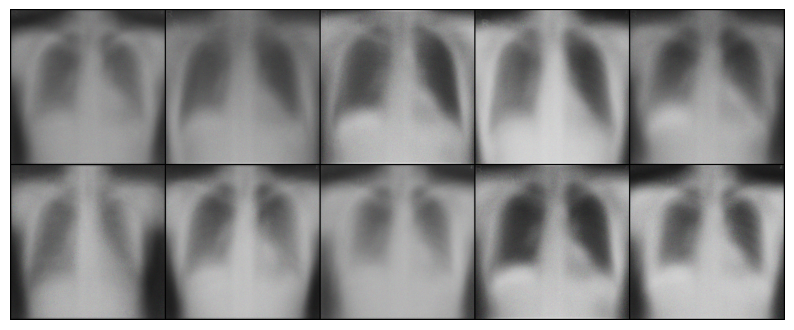

[Epoch 11/100] [Batch 137/138] [D loss: 0.5533196926116943] [G loss: 1.0051487684249878]
[Epoch 12/100] [Batch 137/138] [D loss: 0.4909474849700928] [G loss: 0.8768844604492188]
[Epoch 13/100] [Batch 137/138] [D loss: 0.5255818963050842] [G loss: 0.8928268551826477]
[Epoch 14/100] [Batch 137/138] [D loss: 0.4556959867477417] [G loss: 1.5495039224624634]
[Epoch 15/100] [Batch 137/138] [D loss: 0.563636064529419] [G loss: 0.9695461392402649]
[Epoch 16/100] [Batch 137/138] [D loss: 0.4397318363189697] [G loss: 1.220319390296936]
[Epoch 17/100] [Batch 137/138] [D loss: 0.5786962509155273] [G loss: 0.6748685240745544]
[Epoch 18/100] [Batch 137/138] [D loss: 0.45162272453308105] [G loss: 1.588459849357605]
[Epoch 19/100] [Batch 137/138] [D loss: 0.4822496771812439] [G loss: 1.5256702899932861]
[Epoch 20/100] [Batch 137/138] [D loss: 0.3662872910499573] [G loss: 1.4207541942596436]


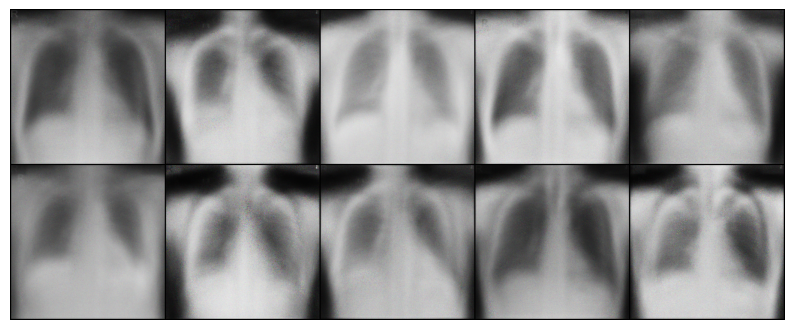

[Epoch 21/100] [Batch 137/138] [D loss: 0.730583131313324] [G loss: 2.2861287593841553]
[Epoch 22/100] [Batch 137/138] [D loss: 0.460710734128952] [G loss: 0.9004136919975281]
[Epoch 23/100] [Batch 137/138] [D loss: 0.4786190688610077] [G loss: 1.1483697891235352]
[Epoch 24/100] [Batch 137/138] [D loss: 0.6372624635696411] [G loss: 0.7303658723831177]
[Epoch 25/100] [Batch 137/138] [D loss: 0.4246017336845398] [G loss: 0.9623302817344666]
[Epoch 26/100] [Batch 137/138] [D loss: 0.6919387578964233] [G loss: 0.7654065489768982]
[Epoch 27/100] [Batch 137/138] [D loss: 0.34049561619758606] [G loss: 1.285437822341919]
[Epoch 28/100] [Batch 137/138] [D loss: 0.5344547629356384] [G loss: 1.3011775016784668]
[Epoch 29/100] [Batch 137/138] [D loss: 0.5723178386688232] [G loss: 1.7096933126449585]
[Epoch 30/100] [Batch 137/138] [D loss: 0.5359799265861511] [G loss: 1.1942375898361206]


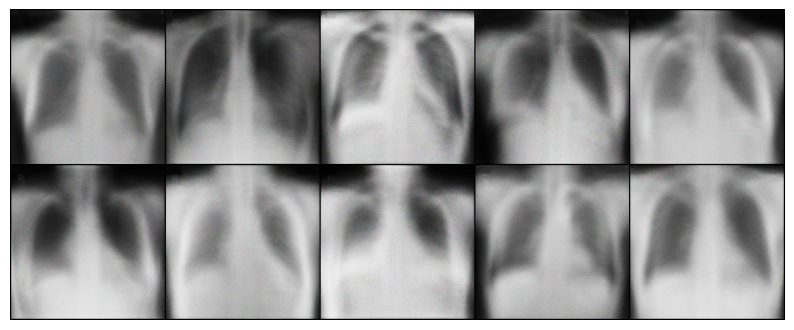

[Epoch 31/100] [Batch 137/138] [D loss: 0.6055315732955933] [G loss: 1.3094648122787476]
[Epoch 32/100] [Batch 137/138] [D loss: 0.6905934810638428] [G loss: 1.0755366086959839]
[Epoch 33/100] [Batch 137/138] [D loss: 0.468178927898407] [G loss: 0.9771406054496765]
[Epoch 34/100] [Batch 137/138] [D loss: 0.5169931054115295] [G loss: 0.9214937090873718]
[Epoch 35/100] [Batch 137/138] [D loss: 0.3718433976173401] [G loss: 1.5776628255844116]
[Epoch 36/100] [Batch 137/138] [D loss: 0.408324658870697] [G loss: 1.3620637655258179]
[Epoch 37/100] [Batch 137/138] [D loss: 0.4887460470199585] [G loss: 0.965541660785675]
[Epoch 38/100] [Batch 137/138] [D loss: 0.4648817479610443] [G loss: 1.0552574396133423]
[Epoch 39/100] [Batch 137/138] [D loss: 0.5786578059196472] [G loss: 0.8708462119102478]
[Epoch 40/100] [Batch 137/138] [D loss: 0.434781938791275] [G loss: 1.237528681755066]


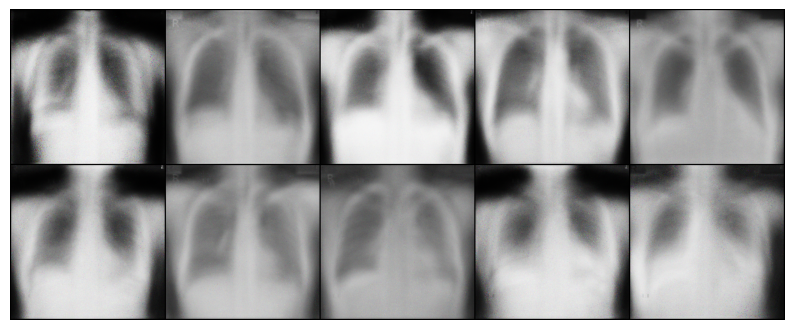

[Epoch 41/100] [Batch 137/138] [D loss: 0.5989776849746704] [G loss: 0.9838312268257141]
[Epoch 42/100] [Batch 137/138] [D loss: 0.4305867552757263] [G loss: 1.0234543085098267]
[Epoch 43/100] [Batch 137/138] [D loss: 0.5256209969520569] [G loss: 0.8404678702354431]
[Epoch 44/100] [Batch 137/138] [D loss: 0.4970126152038574] [G loss: 1.2744834423065186]
[Epoch 45/100] [Batch 137/138] [D loss: 0.3796122074127197] [G loss: 1.5961720943450928]
[Epoch 46/100] [Batch 137/138] [D loss: 0.47586530447006226] [G loss: 1.5257190465927124]
[Epoch 47/100] [Batch 137/138] [D loss: 0.44255608320236206] [G loss: 1.0481023788452148]
[Epoch 48/100] [Batch 137/138] [D loss: 0.5119502544403076] [G loss: 0.9681795239448547]
[Epoch 49/100] [Batch 137/138] [D loss: 0.4767967164516449] [G loss: 1.015851378440857]
[Epoch 50/100] [Batch 137/138] [D loss: 0.6028910875320435] [G loss: 0.7983984351158142]


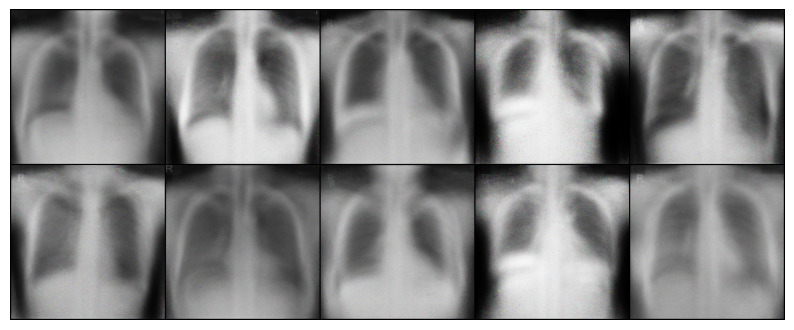

[Epoch 51/100] [Batch 137/138] [D loss: 0.5370679497718811] [G loss: 1.6191612482070923]
[Epoch 52/100] [Batch 137/138] [D loss: 0.45540109276771545] [G loss: 1.578436255455017]
[Epoch 53/100] [Batch 137/138] [D loss: 0.5131561756134033] [G loss: 1.0596399307250977]
[Epoch 54/100] [Batch 137/138] [D loss: 0.5191830992698669] [G loss: 1.993586540222168]
[Epoch 55/100] [Batch 137/138] [D loss: 0.375601589679718] [G loss: 1.4693653583526611]
[Epoch 56/100] [Batch 137/138] [D loss: 0.6730099320411682] [G loss: 0.5395141839981079]
[Epoch 57/100] [Batch 137/138] [D loss: 0.4733494520187378] [G loss: 1.0235756635665894]
[Epoch 58/100] [Batch 137/138] [D loss: 0.5434409379959106] [G loss: 1.3852952718734741]
[Epoch 59/100] [Batch 137/138] [D loss: 0.3890838325023651] [G loss: 1.3100961446762085]
[Epoch 60/100] [Batch 137/138] [D loss: 0.5941832661628723] [G loss: 0.61299067735672]


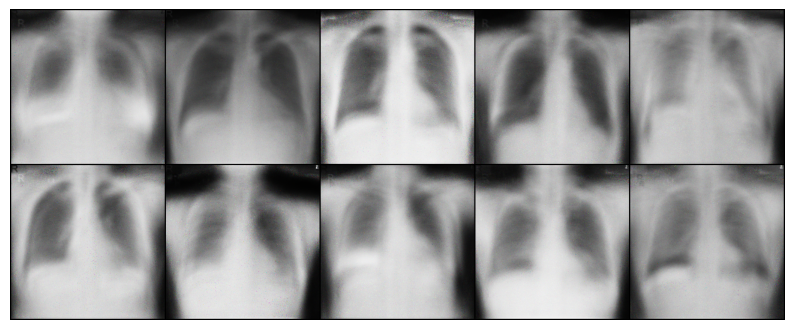

[Epoch 61/100] [Batch 137/138] [D loss: 0.33280453085899353] [G loss: 1.8922442197799683]
[Epoch 62/100] [Batch 137/138] [D loss: 0.38530153036117554] [G loss: 1.8039671182632446]
[Epoch 63/100] [Batch 137/138] [D loss: 0.5756667852401733] [G loss: 2.1594982147216797]
[Epoch 64/100] [Batch 137/138] [D loss: 0.3994590938091278] [G loss: 1.2134712934494019]
[Epoch 65/100] [Batch 137/138] [D loss: 0.44259822368621826] [G loss: 1.3015707731246948]
[Epoch 66/100] [Batch 137/138] [D loss: 0.4745578169822693] [G loss: 1.488705039024353]
[Epoch 67/100] [Batch 137/138] [D loss: 0.43968465924263] [G loss: 1.3466249704360962]
[Epoch 68/100] [Batch 137/138] [D loss: 0.3863028883934021] [G loss: 1.8635574579238892]
[Epoch 69/100] [Batch 137/138] [D loss: 0.5400072336196899] [G loss: 1.7134538888931274]
[Epoch 70/100] [Batch 137/138] [D loss: 0.4311257004737854] [G loss: 0.8525733947753906]


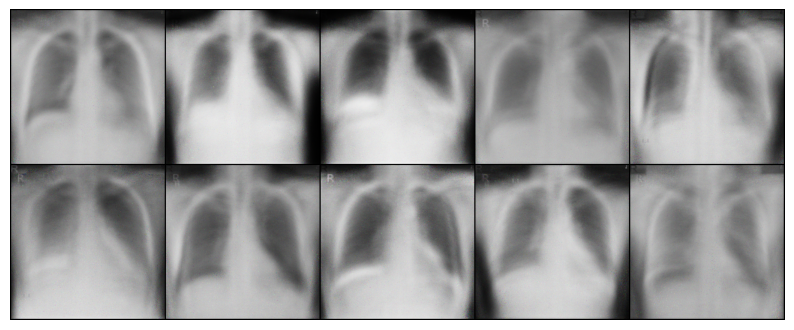

[Epoch 71/100] [Batch 137/138] [D loss: 0.4535239338874817] [G loss: 2.2887942790985107]
[Epoch 72/100] [Batch 137/138] [D loss: 0.38831475377082825] [G loss: 1.178235411643982]
[Epoch 73/100] [Batch 137/138] [D loss: 0.8690550327301025] [G loss: 4.48742151260376]
[Epoch 74/100] [Batch 137/138] [D loss: 0.3711298704147339] [G loss: 1.2249863147735596]
[Epoch 75/100] [Batch 137/138] [D loss: 0.3393346965312958] [G loss: 2.0480687618255615]
[Epoch 76/100] [Batch 137/138] [D loss: 0.32422763109207153] [G loss: 2.4539146423339844]
[Epoch 77/100] [Batch 137/138] [D loss: 0.28340834379196167] [G loss: 1.5913779735565186]
[Epoch 78/100] [Batch 137/138] [D loss: 0.2592628300189972] [G loss: 1.7136039733886719]
[Epoch 79/100] [Batch 137/138] [D loss: 0.12945647537708282] [G loss: 2.3499562740325928]
[Epoch 80/100] [Batch 137/138] [D loss: 0.31338122487068176] [G loss: 1.4622406959533691]


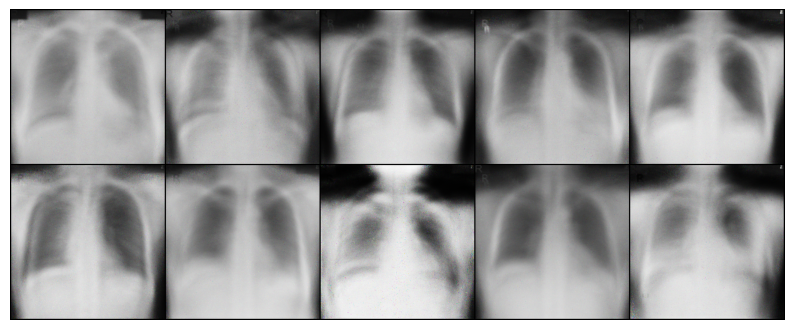

[Epoch 81/100] [Batch 137/138] [D loss: 0.35042884945869446] [G loss: 2.3422868251800537]
[Epoch 82/100] [Batch 137/138] [D loss: 0.37361007928848267] [G loss: 2.2300498485565186]
[Epoch 83/100] [Batch 137/138] [D loss: 0.5116000175476074] [G loss: 1.5414146184921265]
[Epoch 84/100] [Batch 137/138] [D loss: 0.6018810272216797] [G loss: 2.3762741088867188]
[Epoch 85/100] [Batch 137/138] [D loss: 0.4556346535682678] [G loss: 1.888039469718933]
[Epoch 86/100] [Batch 137/138] [D loss: 0.2827765941619873] [G loss: 2.0848443508148193]
[Epoch 87/100] [Batch 137/138] [D loss: 0.3604588210582733] [G loss: 2.4837632179260254]
[Epoch 88/100] [Batch 137/138] [D loss: 0.5312622785568237] [G loss: 1.9224426746368408]
[Epoch 89/100] [Batch 137/138] [D loss: 0.37209755182266235] [G loss: 2.1306190490722656]
[Epoch 90/100] [Batch 137/138] [D loss: 0.41267603635787964] [G loss: 1.3341007232666016]


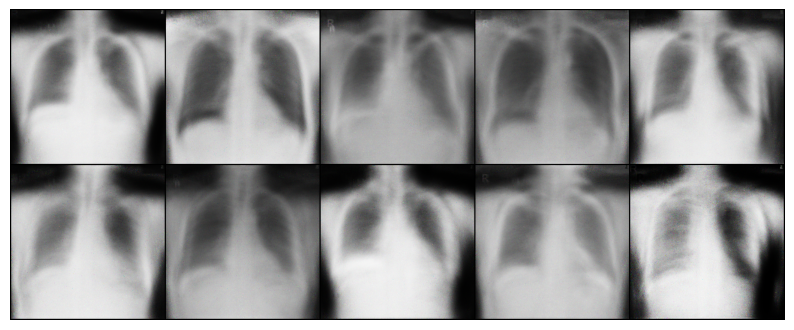

[Epoch 91/100] [Batch 137/138] [D loss: 0.3073333501815796] [G loss: 2.117410659790039]
[Epoch 92/100] [Batch 137/138] [D loss: 0.2561017572879791] [G loss: 2.3824968338012695]
[Epoch 93/100] [Batch 137/138] [D loss: 0.35508352518081665] [G loss: 1.9393287897109985]
[Epoch 94/100] [Batch 137/138] [D loss: 0.34991583228111267] [G loss: 1.2371002435684204]
[Epoch 95/100] [Batch 137/138] [D loss: 0.4038655161857605] [G loss: 1.1390880346298218]
[Epoch 96/100] [Batch 137/138] [D loss: 0.3272455930709839] [G loss: 1.7085485458374023]
[Epoch 97/100] [Batch 137/138] [D loss: 0.21130038797855377] [G loss: 2.646198272705078]
[Epoch 98/100] [Batch 137/138] [D loss: 0.6576066613197327] [G loss: 3.5095787048339844]
[Epoch 99/100] [Batch 137/138] [D loss: 0.32452139258384705] [G loss: 3.2561721801757812]
{0: {'generator_loss': 0.7857099277683554, 'discriminator_loss': 0.6080775929722881}, 1: {'generator_loss': 0.7919177276932675, 'discriminator_loss': 0.3849524492802827}, 2: {'generator_loss': 0.77

In [8]:
import torch
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go

# Function to display and save generated images
def show_and_save_generated(imgs, labels, epoch, generated_images_dir, num_images=10):
    # Rescale images from [-1,1] to [0,1]
    imgs = (imgs + 1) / 2
    # Create grid of images
    grid = make_grid(imgs[:num_images], nrow=5).detach().cpu()
    # Convert grid to numpy array
    grid = grid.numpy().transpose((1, 2, 0))
    # Display grid of images
    plt.figure(figsize=(10, 5))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

    # Save individual images
    for i, img in enumerate(imgs):
        class_label = 'Diseased' if labels[i].item() == 0 else 'No_Disease'
        class_dir = os.path.join(generated_images_dir, class_label)
        os.makedirs(class_dir, exist_ok=True)  # Create the class directory if it doesn't exist
        image_path = os.path.join(class_dir, f'epoch_{epoch}_image_{i}.png')
        save_image(img, image_path)

# Define a directory to save model checkpoints
checkpoint_dir = '/kaggle/working/checkpoints_vgans/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define a directory to save generated images
generated_images_dir = '/kaggle/working/generated_images_vgans/'
os.makedirs(generated_images_dir, exist_ok=True)

# Initialize lists to store losses
g_losses = []
d_losses = []

# Define a dictionary to store epoch losses
epoch_losses = {}

# Training Loop
for epoch in range(epochs):
    epoch_g_loss = 0.0  # Initialize epoch generator loss
    epoch_d_loss = 0.0  # Initialize epoch discriminator loss
    for i, (imgs, labels) in enumerate(dataloader):
        
        valid = torch.ones(imgs.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False).to(device)
        
        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device)
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = torch.randn(imgs.size(0), z_dim).to(device)
        gen_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
    
    # Calculate average losses for this epoch
    avg_g_loss = epoch_g_loss / len(dataloader)
    avg_d_loss = epoch_d_loss / len(dataloader)
    
    # Store the epoch number and losses in the dictionary
    epoch_losses[epoch] = {'generator_loss': avg_g_loss, 'discriminator_loss': avg_d_loss}
        
    print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

    # Save model checkpoints every 10 epochs and display grid of images
    if epoch % 10 == 0:
        torch.save(generator.state_dict(), os.path.join(checkpoint_dir, f'generator_epoch_{epoch}.pth'))
        torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, f'discriminator_epoch_{epoch}.pth'))

        # Generate and save example images
        with torch.no_grad():
            z_example = torch.randn(10, z_dim).to(device)  # Generate 10 random noise vectors
            gen_labels_example = torch.randint(0, n_classes, (10,)).to(device)  # Generate random labels
            gen_imgs_example = generator(z_example, gen_labels_example)
            show_and_save_generated(gen_imgs_example, gen_labels_example, epoch, generated_images_dir, num_images=10)

# Print epoch_losses to see the structure of the dictionary
print(epoch_losses)

# Convert epoch_losses dictionary to lists
epochs_list = list(epoch_losses.keys())
generator_losses_list = [entry['generator_loss'] for entry in epoch_losses.values()]
discriminator_losses_list = [entry['discriminator_loss'] for entry in epoch_losses.values()]

# Create Plotly figure
fig = go.Figure()

# Add generator loss trace
fig.add_trace(go.Scatter(x=epochs_list, y=generator_losses_list, mode='lines', name='Generator Loss'))

# Add discriminator loss trace
fig.add_trace(go.Scatter(x=epochs_list, y=discriminator_losses_list, mode='lines', name='Discriminator Loss'))

# Update layout
fig.update_layout(
    title='Generator and Discriminator Losses Over Epochs',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    legend=dict(x=0, y=1),
)

# Show plot
fig.show()
